# Dirty ER - Workflows


In this notebook it's implemented the 3 basic JedAI workflows for Dirty Entity Resolution


## WorkFlow 1



In [ ]:
%pip install strsimpy

Libraries import

In [1]:
from html import entities
import os
import sys
import pandas as pd
import networkx
from networkx import (
    draw,
    DiGraph,
    Graph,
)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

Import JedAI utilities

In [3]:
from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs

Import of evaluation module

In [4]:
from pyjedai.evaluation import Evaluation

### Data Reading

In [5]:
from pyjedai.datamodel import Data

#### CSV format

In [7]:
d1 = pd.read_csv("./data/cora/cora.csv", sep='|')
gt = pd.read_csv("./data/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']

#### JSON format

In [ ]:
d1 = pd.read_json("./data/cora/cora.json")
gt = pd.read_json("./data/cora/cora_gt.csv")
attr = ['author', 'title']

#### RDF format

In [ ]:
import rdfpandas as rfd
import pandas as pd
import rdflib

g1 = rdflib.Graph()
g1.parse('d1.ttl', format = 'ttl')
g_gt = rdflib.Graph()
g_gt.parse('d1.ttl', format = 'ttl')

d1 = rfd.graph.to_dataframe(g1)
gt = rfd.graph.to_dataframe(g_gt)

#### Relational DB

#### SPARKQL

Data is the connecting module of all steps of the workflow

In [10]:
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

data.process()

### Schema Clustering

In [ ]:
# import valentine
# # Instantiate matcher and run
# matcher = Coma(strategy="COMA_OPT")
# matches = valentine_match(df1, df2, matcher)

### Block Building

In [13]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking,
    ExtendedQGramsBlocking
)

In [14]:
blocks = StandardBlocking().build_blocks(data)

Standard Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [15]:
blocks = QGramsBlocking(
    qgrams=2
).build_blocks(data)

Q-Grams Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [16]:
blocks = SuffixArraysBlocking(
    suffix_length=2
).build_blocks(data)

Suffix Arrays Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [17]:
blocks = ExtendedSuffixArraysBlocking(
    suffix_length=2
).build_blocks(data)

Extended Suffix Arrays Blocking:   0%|          | 0/1295 [00:00<?, ?it/s]

In [18]:
Evaluation(data).report(blocks)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      1.75% 
Recall:        48.14%
F1-score:       3.39%

True positives: 8273
False positives: 463295
True negatives: 365659
False negatives: 8911

Total comparisons: 471568


### Block Cleaning

In [19]:
from pyjedai.block_cleaning import (
    BlockFiltering
)

In [20]:
filtered_blocks = BlockFiltering(
    ratio=0.9
).process(blocks, data)

Block Filtering:   0%|                                                                                        …

In [21]:
Evaluation(data).report(filtered_blocks)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      2.09% 
Recall:        46.45%
F1-score:       4.00%

True positives: 7982
False positives: 374210
True negatives: 454453
False negatives: 9202

Total comparisons: 382192


### Comparison Cleaning - Meta Blocking

In [23]:
from pyjedai.block_cleaning import (
    BlockPurging
)

In [24]:
cleaned_blocks = BlockPurging(
    smoothing_factor=0.008
).process(blocks, data)

Block Purging:   0%|          | 0/8088 [00:00<?, ?it/s]

In [25]:
Evaluation(data).report(cleaned_blocks)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      2.65% 
Recall:         0.52%
F1-score:       0.87%

True positives: 89
False positives: 3272
True negatives: 817498
False negatives: 17095

Total comparisons: 3361


In [27]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    # ReciprocalCardinalityWeightPruning,
    ComparisonPropagation
)

In [28]:
candidate_pairs_blocks = WeightedEdgePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data)

Weighted Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [29]:
candidate_pairs_blocks = WeightedNodePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Weighted Node Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [30]:
candidate_pairs_blocks = CardinalityEdgePruning(
    weighting_scheme='CBS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Cardinality Edge Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [31]:
candidate_pairs_blocks = CardinalityNodePruning(
    weighting_scheme='JS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Cardinality Node Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [32]:
candidate_pairs_blocks = BLAST(
    weighting_scheme='JS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

BLAST:   0%|          | 0/1295 [00:00<?, ?it/s]

In [34]:
candidate_pairs_blocks = ReciprocalCardinalityNodePruning(
    weighting_scheme='JS'
).process(filtered_blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Reciprocal Cardinality Node Pruning:   0%|          | 0/1295 [00:00<?, ?it/s]

In [36]:
candidate_pairs_blocks = ComparisonPropagation().process(blocks, data)

# In one case valid entities set is empty and crushed / what to do in this case, Java doesnt handle it

Comparison Propagation:   0%|          | 0/1295 [00:00<?, ?it/s]

In [37]:
Evaluation(data).report(candidate_pairs_blocks)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:     14.80% 
Recall:        48.14%
F1-score:      22.64%

True positives: 8273
False positives: 47632
True negatives: 781322
False negatives: 8911

Total comparisons: 55905


### Entity Matching

In [38]:
from pyjedai.matching import EntityMatching

In [39]:
attr = ['author', 'title']
# or with weights
attr = {
    'author' : 0.6,
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
    # embedings=None, # gensim
    # attributes=attr,
    # qgram=2 # for ngram metric or jaccard
)

# pairs_graph = EM.predict(blocks, data)

In [41]:
pairs_graph = EM.predict(filtered_blocks, data)

Entity Matching (jaccard):   0%|          | 0/3986 [00:00<?, ?it/s]

In [43]:
attr = {
    'author' : 0.6, 
    'title' : 0.4
}

EM = EntityMatching(
    metric='jaccard', 
    similarity_threshold=0.5
    # embedings=None, # gensim
    # attributes=attr,
    # qgram=2 # for ngram metric or jaccard
)

pairs_graph = EM.predict(candidate_pairs_blocks, data)

Entity Matching (jaccard):   0%|          | 0/1294 [00:00<?, ?it/s]

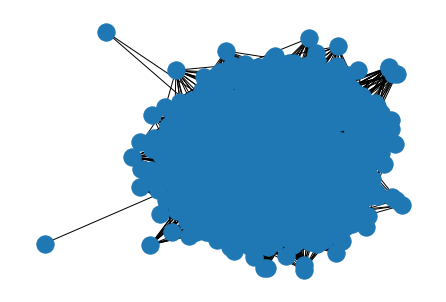

In [45]:
draw(pairs_graph)

In [50]:
e = Evaluation(data)
e.report(pairs_graph)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      1.74% 
Recall:         4.71%
F1-score:       2.54%

True positives: 810
False positives: 45749
True negatives: 775742
False negatives: 16374

Total comparisons: 46559


### Entity Clustering

In [48]:
from pyjedai.clustering import ConnectedComponentsClustering

In [49]:
clusters = ConnectedComponentsClustering().process(pairs_graph)

In [50]:
e = Evaluation(data)
e.report(pairs_graph)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      1.74% 
Recall:         4.71%
F1-score:       2.54%

True positives: 810
False positives: 45749
True negatives: 775742
False negatives: 16374

Total comparisons: 46559


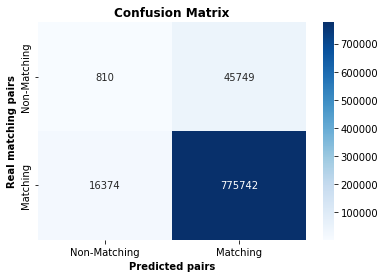

In [51]:
e.confusion_matrix()

## WorkFlow 2



### Data Reading

Data is the connecting module of all steps of the workflow

In [53]:
from pyjedai.datamodel import Data
d1 = pd.read_csv("./data/cora/cora.csv", sep='|')
gt = pd.read_csv("./data/cora/cora_gt.csv", sep='|', header=None)
attr = ['Entity Id','author', 'title']
data = Data(
    dataset_1=d1,
    id_column_name_1='Entity Id',
    ground_truth=gt,
    attributes_1=attr
)

data.process()

### Similarity Joins

In [54]:
from pyjedai.joins import SchemaAgnosticΕJoin, TopKSchemaAgnosticJoin

In [59]:
g = SchemaAgnosticΕJoin(
    threshold = 0.5,
    metric = 'jaccard',
    tokenization = 'qgrams_multiset',
    qgrams = 2
).fit(data)

Schema Agnostic Join (jaccard):   0%|          | 0/2590 [00:00<?, ?it/s]

In [60]:
e = Evaluation(data)
e.report(g)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:     65.49% 
Recall:        90.14%
F1-score:      75.86%

True positives: 15490
False positives: 8162
True negatives: 828009
False negatives: 1694

Total comparisons: 23652


In [57]:
g = TopKSchemaAgnosticJoin(
    K=20,
    metric = 'jaccard',
    tokenization = 'qgrams',
    qgrams = 3
).fit(data)

Top-K Schema Agnostic Join (jaccard):   0%|          | 0/1295 [00:00<?, ?it/s]

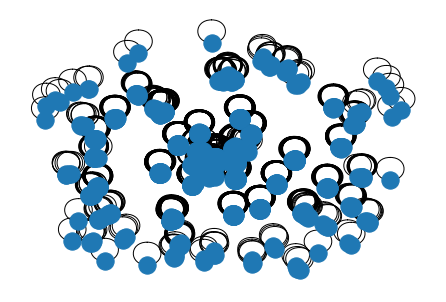

In [67]:
draw(g)

In [58]:
e = Evaluation(data)
e.report(g)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:     55.09% 
Recall:        59.89%
F1-score:      57.39%

True positives: 10292
False positives: 8389
True negatives: 822584
False negatives: 6892

Total comparisons: 18681


### Entity Clustering

In [63]:
from pyjedai.clustering import ConnectedComponentsClustering

In [64]:
clusters = ConnectedComponentsClustering().process(g)

In [65]:
e = Evaluation(data)
e.report(clusters)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:     48.56% 
Recall:        93.18%
F1-score:      63.85%

True positives: 16012
False positives: 16961
True negatives: 819732
False negatives: 1172

Total comparisons: 32973


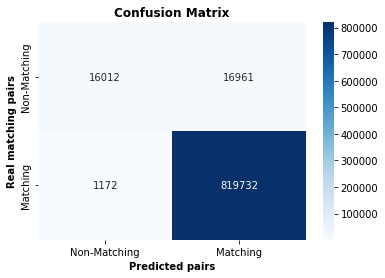

In [66]:
e.confusion_matrix()

## WorkFlow 3

